In [1]:
import requests, io
import pdfplumber
import pandas as pd

In [2]:
url = "https://tournaments.uskidsgolf.com/sites/default/files/priority_status_awards_-_as_of_december_17_2025.pdf"
resp = requests.get(url)
resp.raise_for_status()

tables = []  # list of (page_num, table_index, DataFrame)
with pdfplumber.open(io.BytesIO(resp.content)) as pdf:
    for p_idx, page in enumerate(pdf.pages, start=1):
        page_tables = page.extract_tables()
        if not page_tables:
            continue
        for t_idx, raw_table in enumerate(page_tables, start=1):
            # normalize rows/cols and strip cells
            cleaned = [[(c.strip() if isinstance(c, str) else "") for c in row] for row in raw_table if any(row)]
            if len(cleaned) == 0:
                continue
            df = pd.DataFrame(cleaned)

            # default behavior: use second row as header, keep rows after as data
            df.columns = df.iloc[1]
            df = df.iloc[2:].reset_index(drop=True)

            df = df.replace("", pd.NA)

            # split 'Name' into 'Last Name' and 'First Name' if present
            if 'Name' in df.columns:
                names = df['Name'].astype(str).str.strip()
                has_comma = names.str.contains(',', na=False)

                last = pd.Series(pd.NA, index=df.index)
                first = pd.Series(pd.NA, index=df.index)

                # "Last, First" -> split on comma
                comma_parts = names[has_comma].str.split(',', n=1, expand=True)
                last.loc[has_comma] = comma_parts.iloc[:, 0].str.strip()
                first.loc[has_comma] = comma_parts.iloc[:, 1].str.strip()

                # "First Last" or single name -> split on first space
                no_comma_idx = ~has_comma
                space_parts = names[no_comma_idx].str.split(n=1, expand=True)
                if not space_parts.empty:
                    first.loc[no_comma_idx] = space_parts.iloc[:, 0].str.strip()
                    # if there's no last part, use the whole as last name to avoid missing data
                    last_part = space_parts.iloc[:, 1]
                    last.loc[no_comma_idx] = last_part.fillna(space_parts.iloc[:, 0]).str.strip()

                df['Last Name'] = last
                df['First Name'] = first

            tables.append((p_idx, t_idx, df))



In [3]:
# quick preview: print only entries where Name == "Edison Johnston"
target_name = "Johnston, Edison"
for p, i, df in tables:
    # ensure 'Name' column present
    if 'Name' not in df.columns:
        continue
    # clean name values and filter
    names = df['Name'].astype(str).str.strip()
    matched = df[names.eq(target_name)]
    if not matched.empty:
        print(f"Page {p} — Table {i} — {len(matched)} match(es) for '{target_name}'")
        display(matched)
        matched.to_csv(f"uskids_table_page{p}_t{i}_matches.csv", index=False)

Page 209 — Table 1 — 4 match(es) for 'Johnston, Edison'


1,Name,Status,Status Period,Earned From,Last Name,First Name
55,"Johnston, Edison",Level 9,"Mar 1, 2025 to Feb 28, 2026","Space Coast, FL LT - Fall 2024 - 1st Place (Bo...",Johnston,Edison
56,"Johnston, Edison",Level 6,"Sep 1, 2025 to Aug 31, 2026","Space Coast, FL LT - Spring 2025 - 3rd Place (...",Johnston,Edison
57,"Johnston, Edison",Level 4,"Jan 1, 2026 to Dec 31, 2026",PGA Golf Club Invitational 2025 [Regional] - B...,Johnston,Edison
58,"Johnston, Edison",Level 12,"Mar 1, 2026 to Feb 28, 2027","Space Coast, FL LT - Fall 2025 - 1st Place (Bo...",Johnston,Edison


Status
Level 1      951
Level 2     2247
Level 3     5756
Level 4     2961
Level 5     4744
Level 6     3695
Level 7     4902
Level 8     4998
Level 9     3858
Level 10    1982
Level 11    1952
Level 12    1921
Level 13    1408
Level 14    2022
Lifetime     128
Name: count, dtype: int64


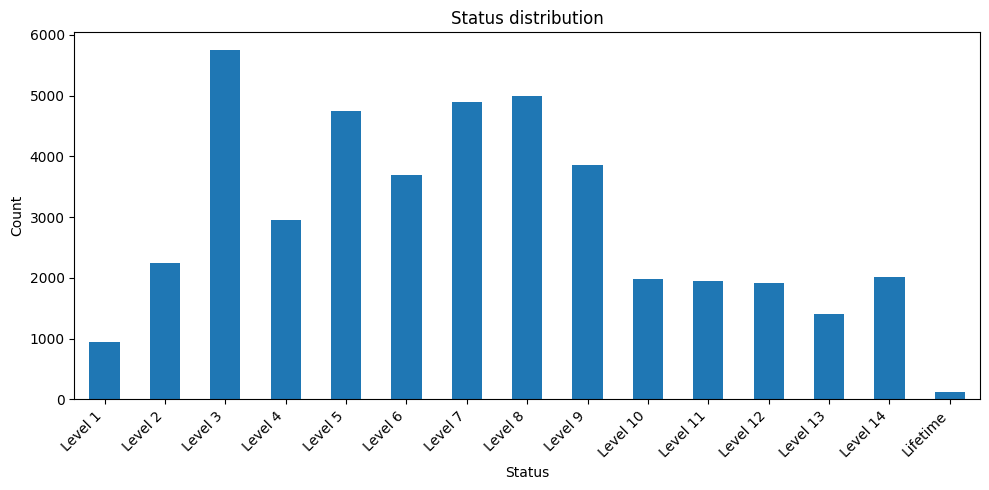

In [6]:
# Status histogram: aggregate 'Status' values across all extracted tables and plot counts
import matplotlib.pyplot as plt

status_series = []
for p, i, df in tables:
    if 'Status' in df.columns:
        s = df['Status'].dropna().astype(str).str.strip()
        if not s.empty:
            status_series.append(s)

if not status_series:
    print("No 'Status' column found in any table.")
else:
    all_status = pd.concat(status_series, ignore_index=True)
    counts = all_status.value_counts()

    # desired ordering: Level 1 .. Level 13, then Lifetime
    desired_order = [f"Level {n}" for n in range(1, 15)] + ["Lifetime"]

    # Reindex counts to include all desired levels (fill missing with 0)
    ordered_counts = counts.reindex(desired_order, fill_value=0)

    # Append any other statuses that aren't in desired_order after the ordered levels
    other = counts[~counts.index.isin(desired_order)]
    if not other.empty:
        ordered_counts = pd.concat([ordered_counts, other])

    print(ordered_counts)
    ordered_counts.to_csv('status_counts.csv')

    plt.figure(figsize=(10,5))
    ordered_counts.plot(kind='bar')
    plt.title('Status distribution')
    plt.xlabel('Status')
    plt.ylabel('Count')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.show()